In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
from osgeo import gdal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

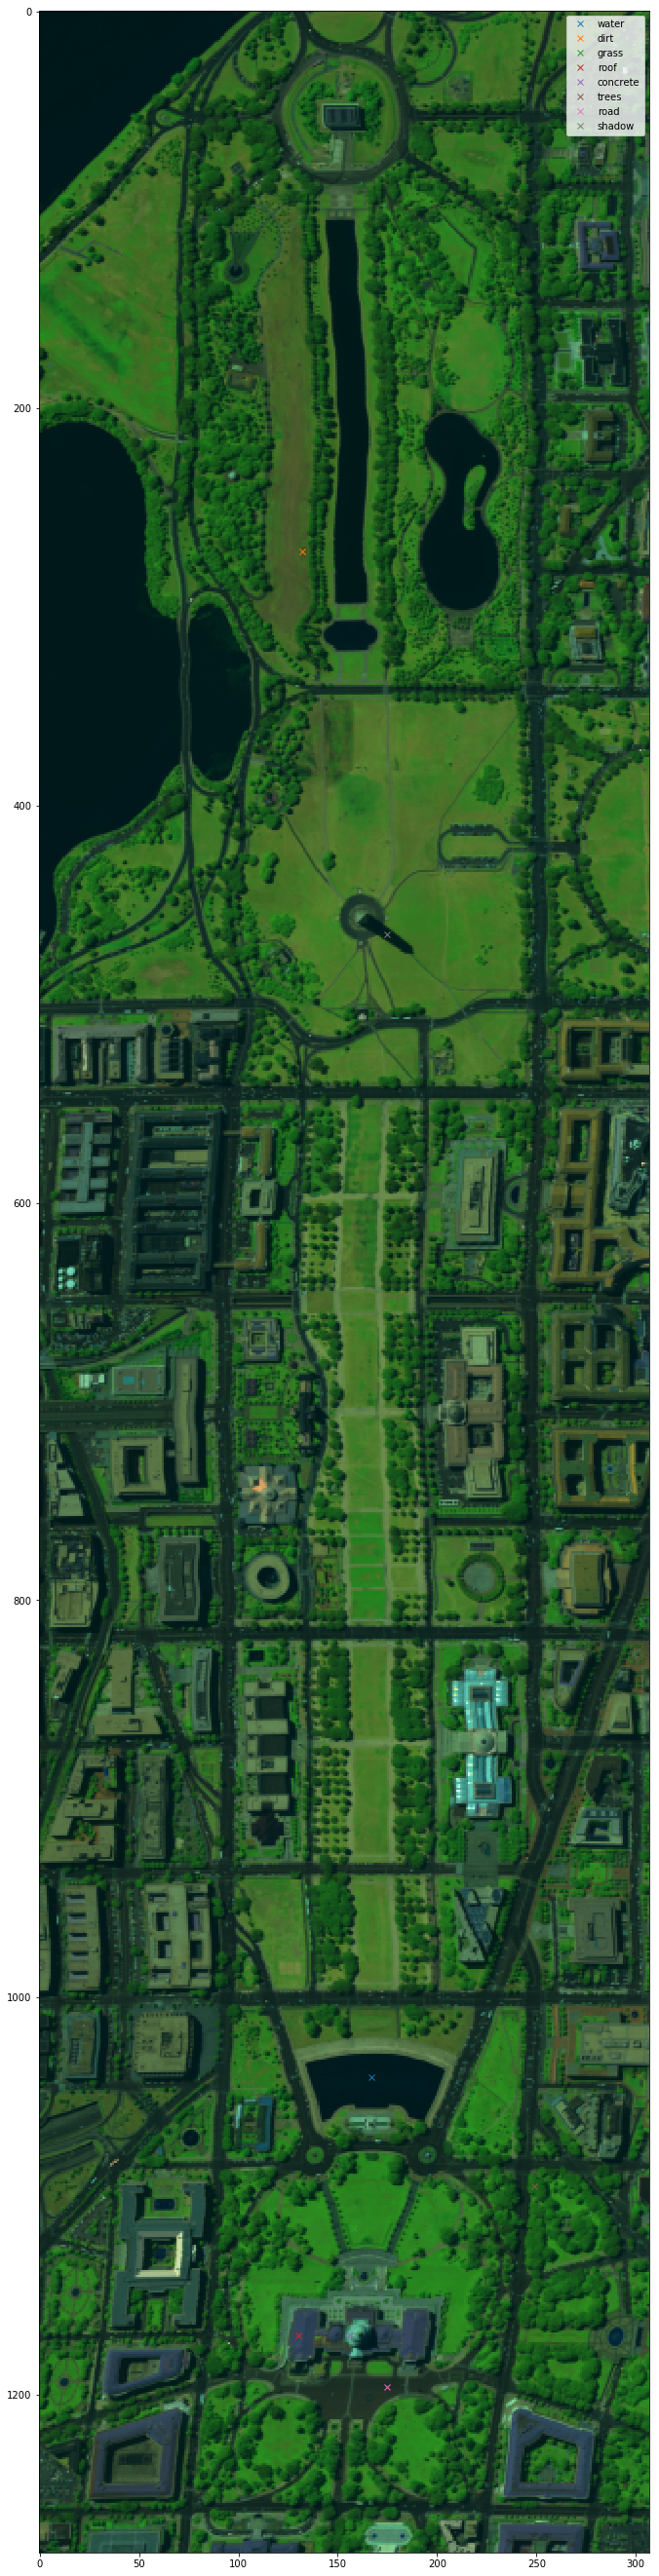

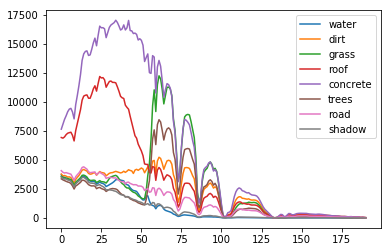

In [2]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])
points = dc.ref_points

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(12,48), show=False);

points = OrderedDict([
    ('water', (167, 1040)),
    ('dirt', (132, 272)),
    ('grass', (158, 1116)),
    #('grass', (166, 1105)),
    ('roof', (130, 1170)),
    ('concrete', (156, 1170)),
    #('trees', (249, 1123)),
    ('trees', (249, 1095)),
    ('road', (175, 1196)),
    #('road', (138, 1086)),
    ('shadow', (175, 465))
    #('shadow', (70, 1160))
])

spectra = OrderedDict()
for obj, pt in points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
plt.legend()
#plt.xlim([62,262])
#plt.ylim([1000,1200])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

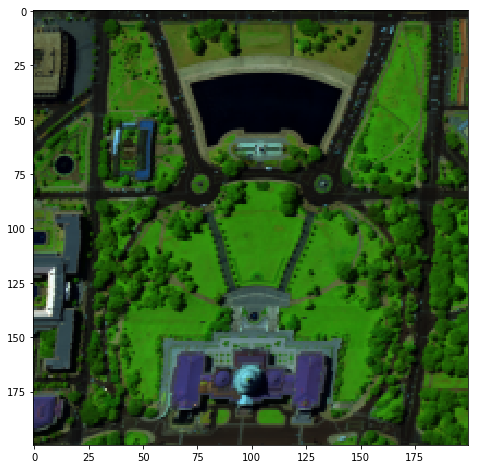

In [3]:
# only use a subset of the image
xmin = 62
xmax = 262
ymin = 1000
ymax = 1200
img_shape = (ymax-ymin, xmax-xmin)
subset = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
subset = subset.reshape(data.shape[0], img_shape[0]*img_shape[1])
dc.plot_color_img(subset, img_shape);

In [4]:
points = dc.ref_points
A0,S0 = dc.init_nmf(subset, img_shape, points, spectra)
Ls = [[None], [np.ones((1,S0.shape[0]))]]

prox_A = proxmin.operators.prox_plus
prox_g = [[proxmin.operators.prox_id],[dc.prox_ones]]

In [5]:
A, S = nmf.nmf(subset, A0, S0, prox_A, max_iter=1000, Ls=Ls, proxs_g=prox_g)

INFO:proxmin.algorithms:Completed 1001 iterations


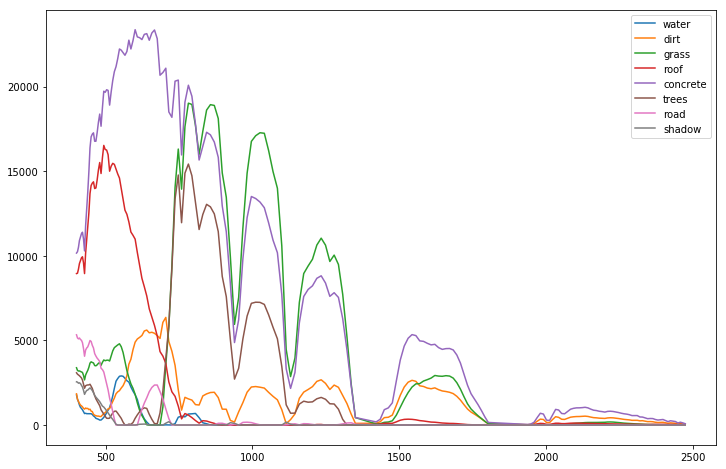

In [6]:
dc.plot_spectra(wavelength, A, points)

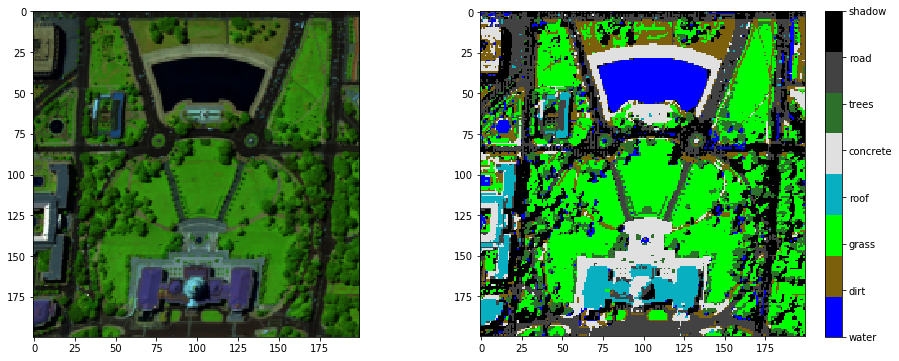

In [7]:
dc.compare_likelihood(subset, img_shape, S, points, figsize=(16,6))

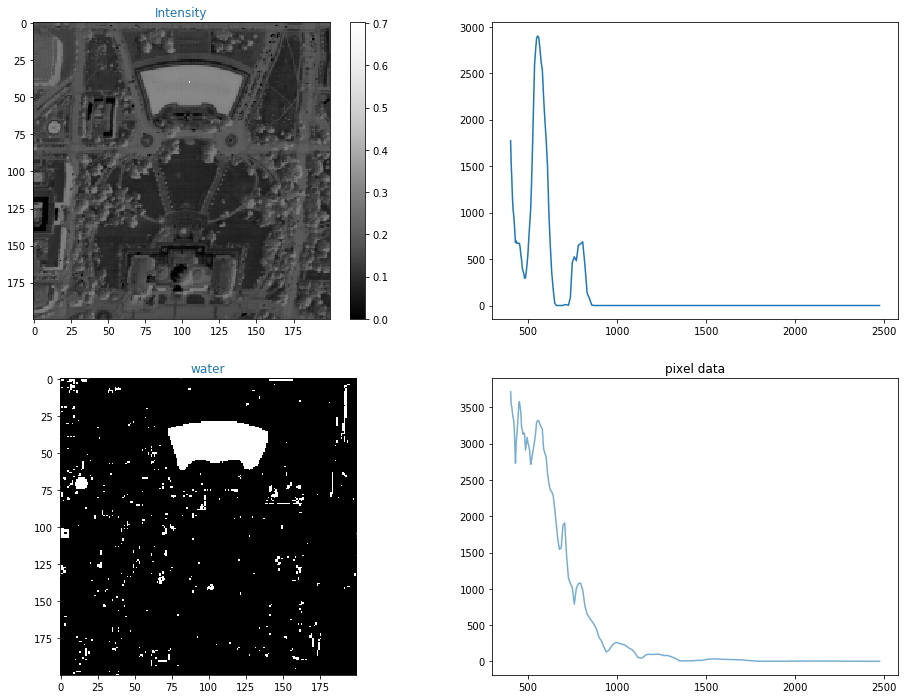

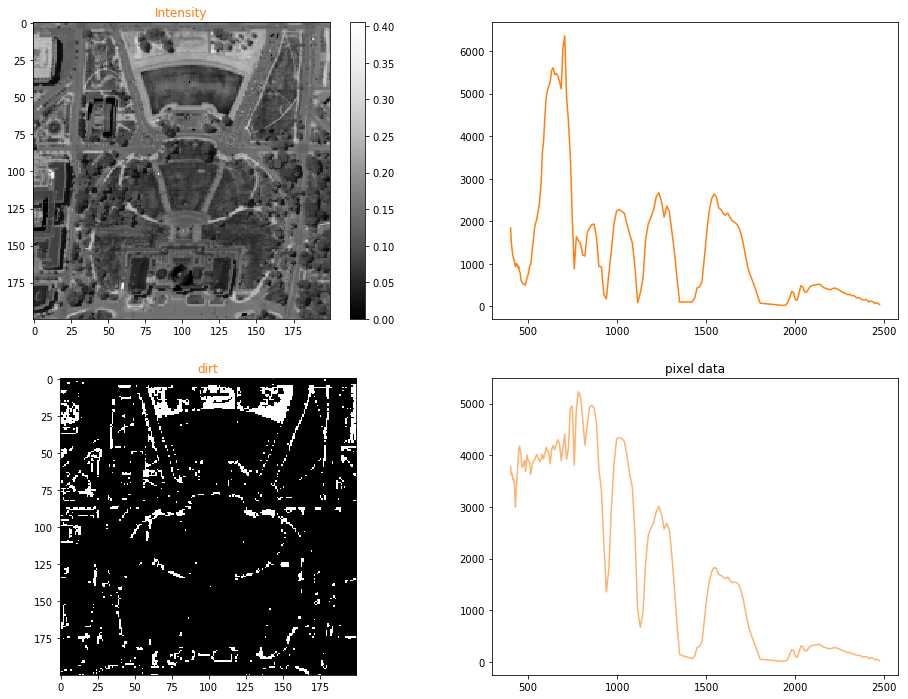

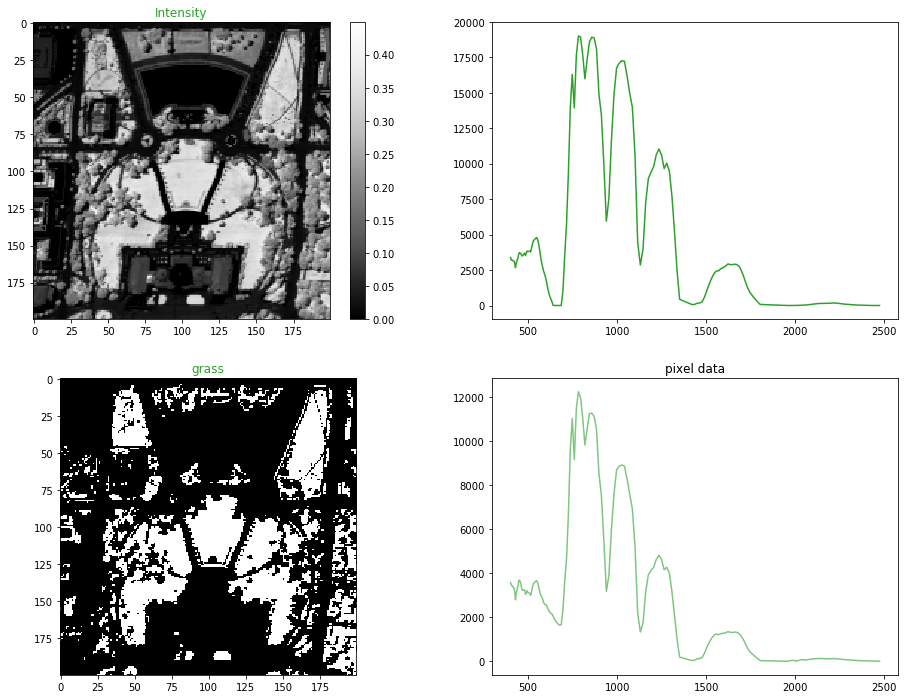

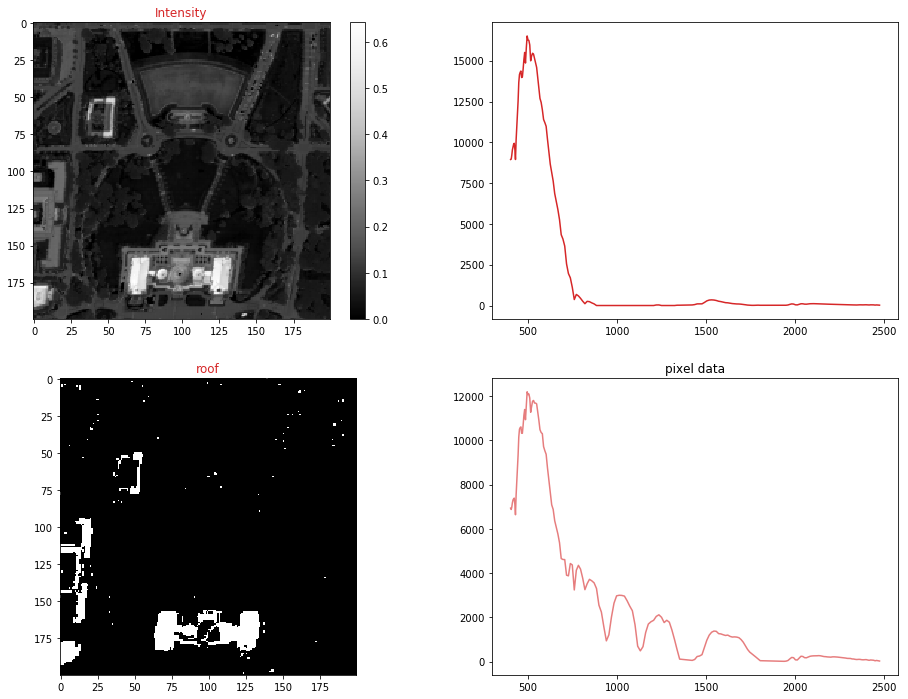

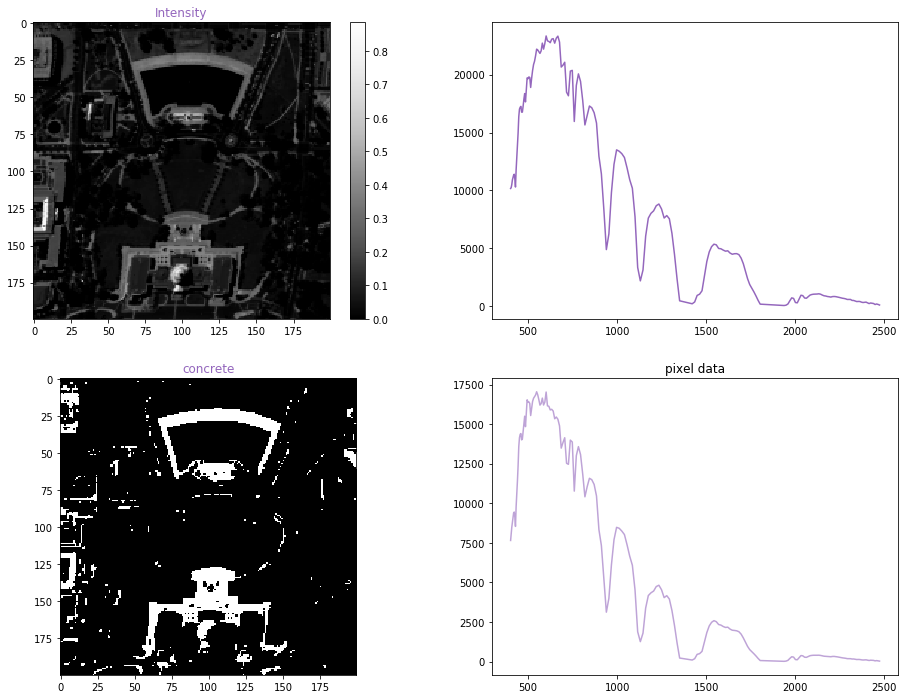

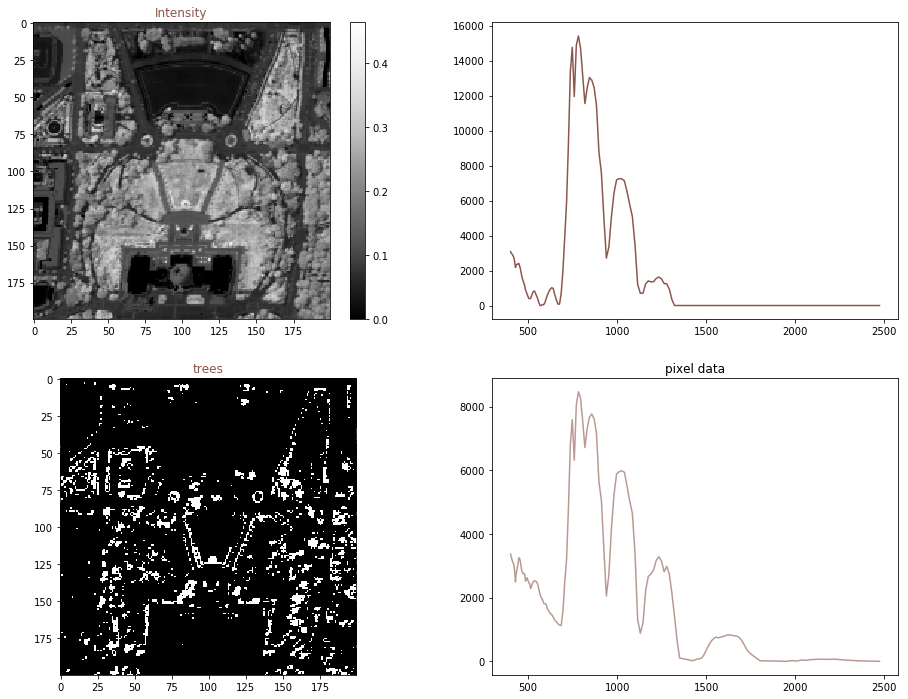

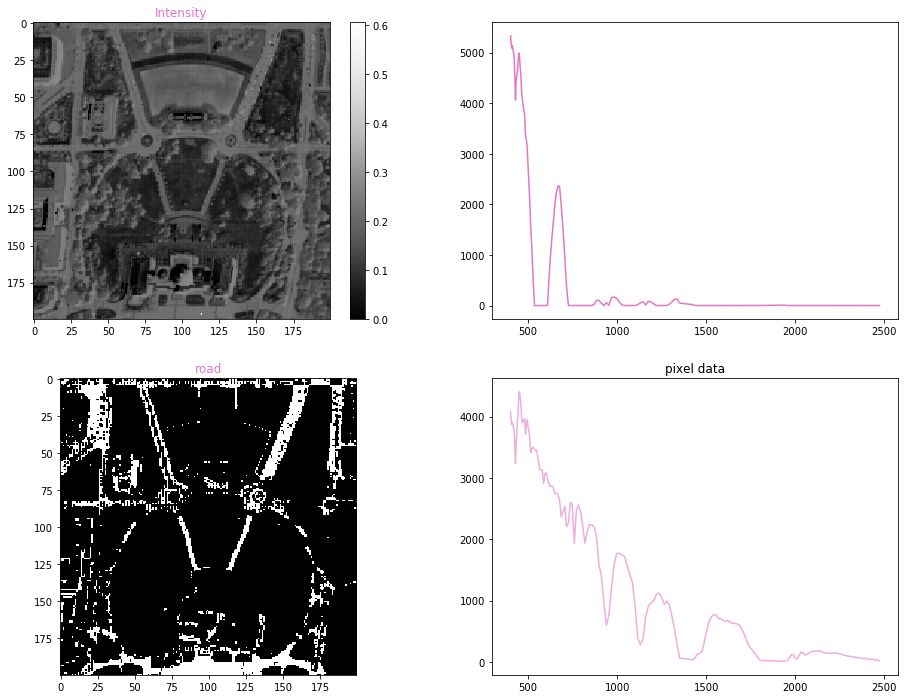

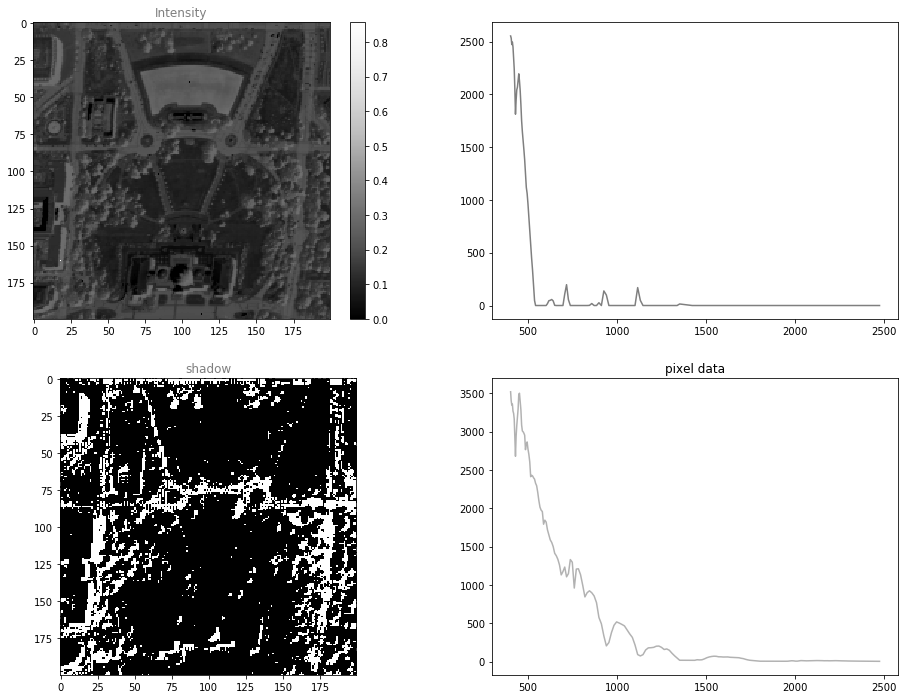

In [8]:
from imp import reload
reload(dc)
dc.plot_objects(subset, A, S, img_shape, points, spectra, wavelength=wavelength)

In [3]:
import scipy.special
import scipy.sparse

def prox_entropy(X, step):
    X = np.abs(scipy.special.lambertw(np.exp(X - 1)))# / step
    return X


A0,S0 = dc.init_nmf(data, img_shape, points)
Ls = [[None], [np.ones((1,S0.shape[0])), np.identity(S0.shape[0])]]

prox_A = proxmin.operators.prox_plus
prox_g = [[proxmin.operators.prox_id],[dc.prox_ones, prox_entropy]]

In [4]:
#A, S = nmf.nmf(data, A0, S0, prox_A, prox_S, max_iter=300)
#A, S = nmf.nmf(data, A0, S0, prox_A, max_iter=300, l1_thresh=1000, Ls=Ls, proxs_g=prox_g)
#A, S = nmf.nmf(data, A0, S0, prox_A, max_iter=1000, Ls=Ls, proxs_g=prox_g, l0_thresh=.1)
A, S = nmf.nmf(data, A0, S0, prox_A, max_iter=100, Ls=Ls, proxs_g=prox_g, steps_g=[[None],[None, None]])
#A, S = nmf.nmf(data, A0, S0, prox_A, prox_entropy, max_iter=1000, Ls=Ls, proxs_g=prox_g)

1 1
2 2


INFO:proxmin.algorithms:Completed 101 iterations


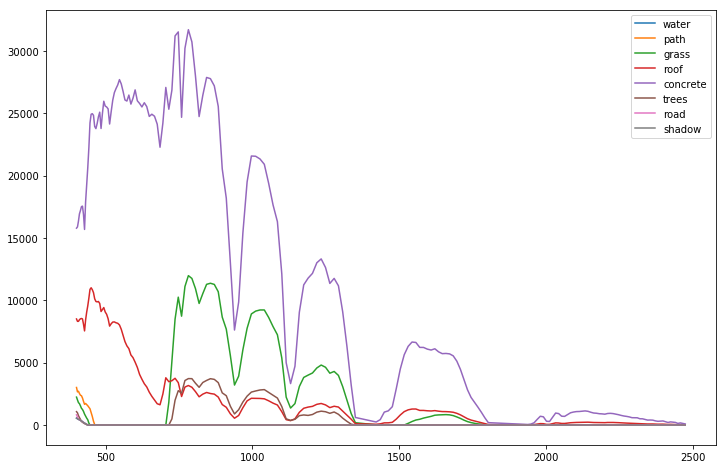

In [6]:
plt.figure(figsize=(12,8))
for row in range(A.shape[1]):
    plt.plot(wavelength, A[:,row], label=list(points.keys())[row])
    #plt.plot(A[:,row], label="Object {0}".format(row))
plt.legend()
plt.show()

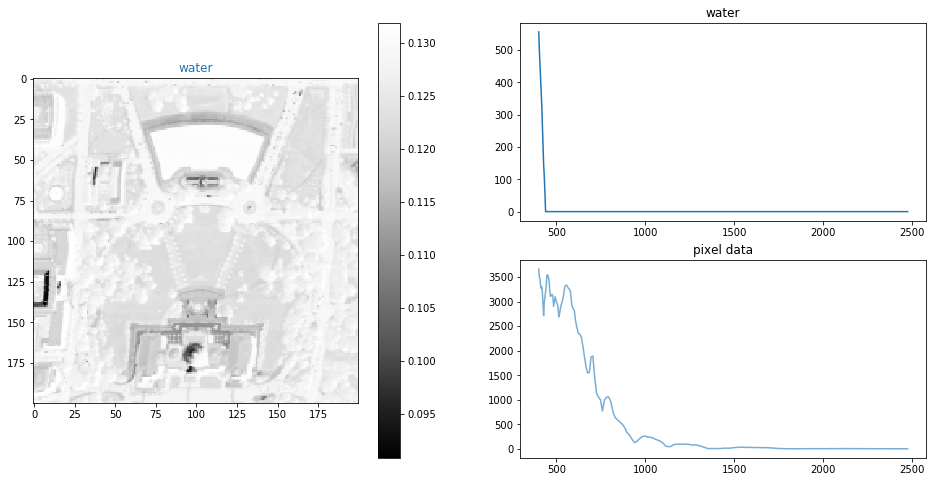

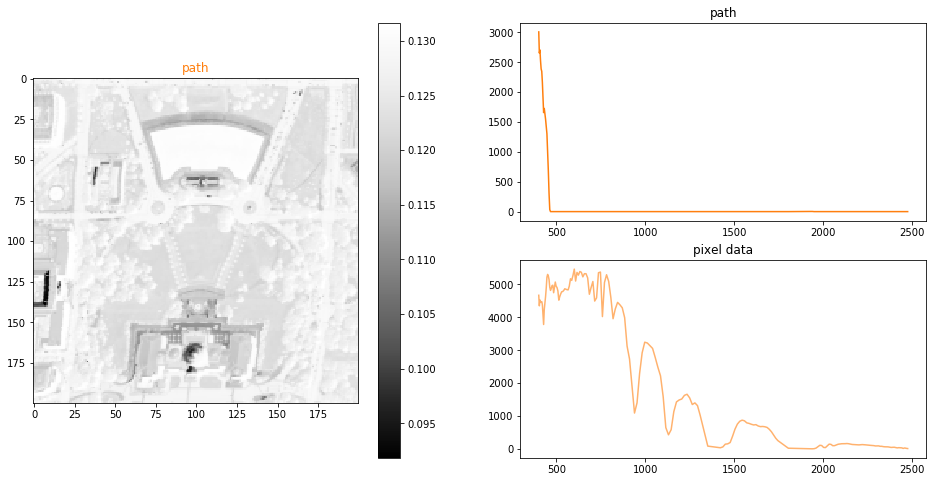

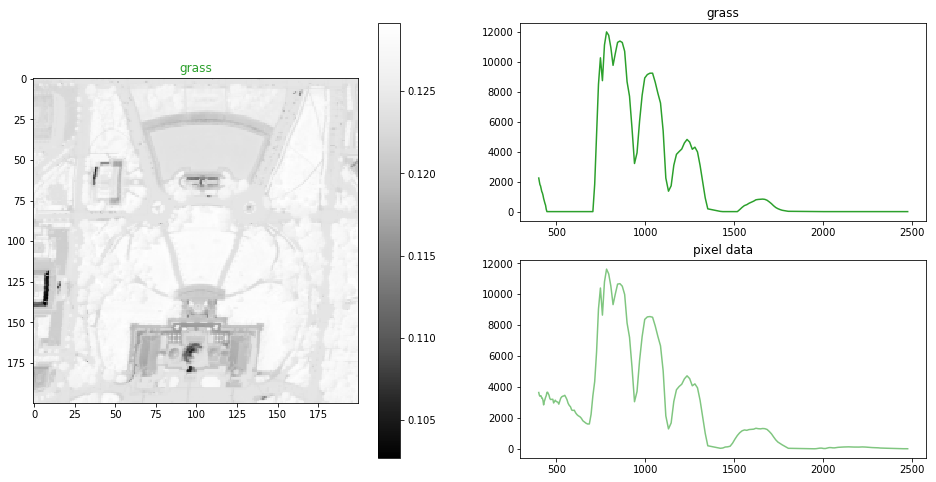

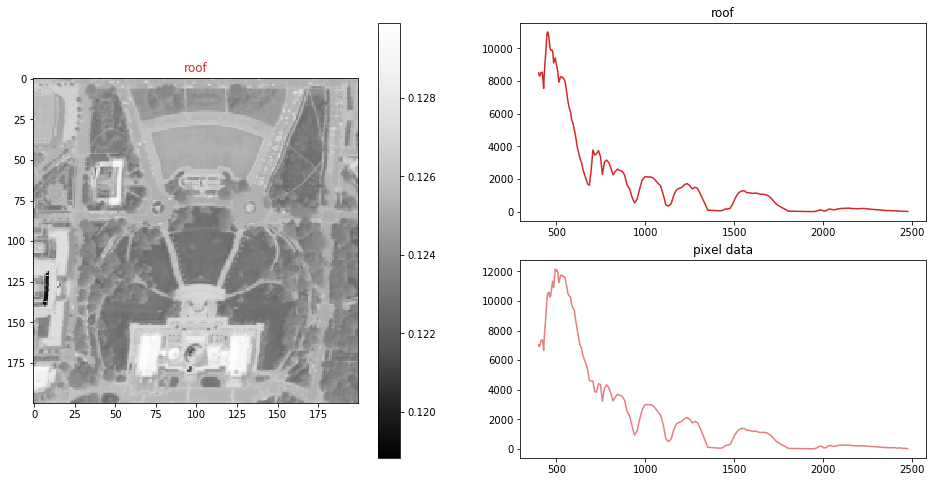

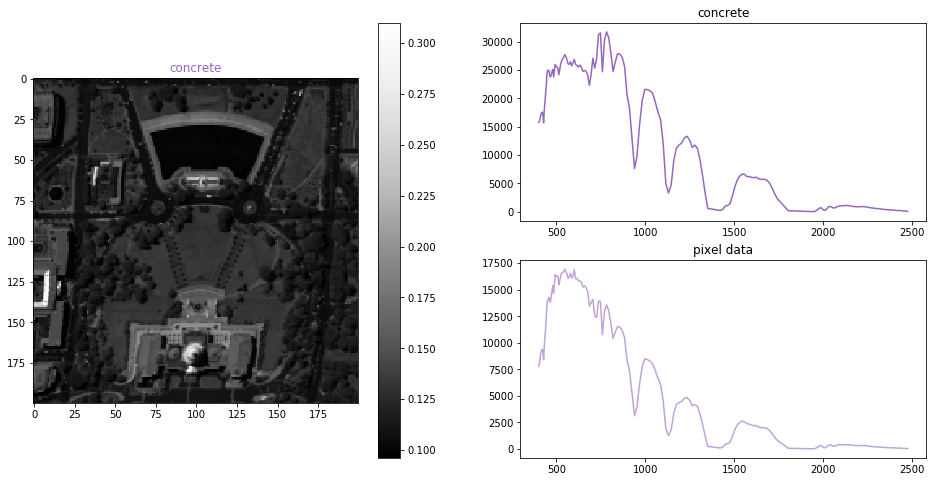

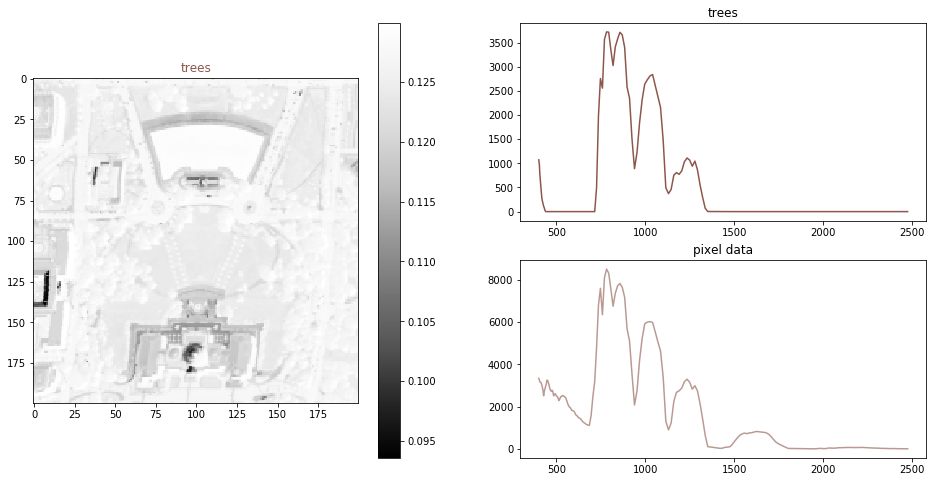

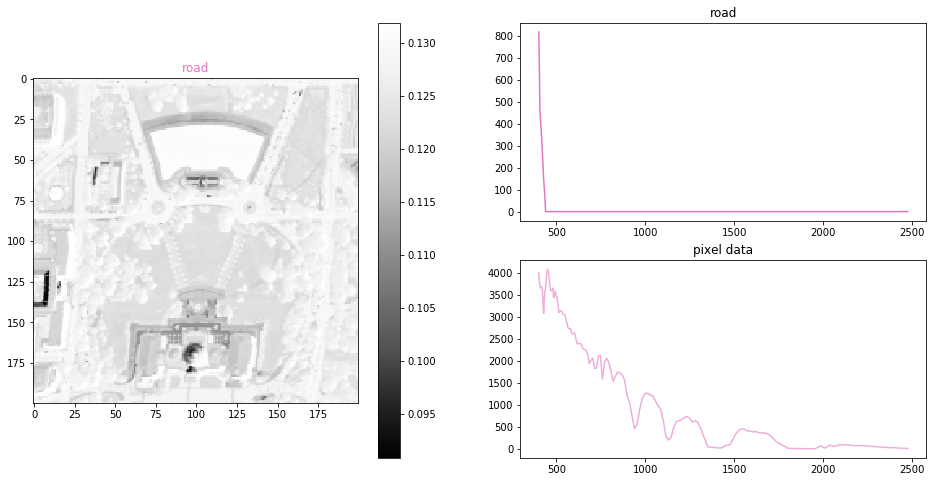

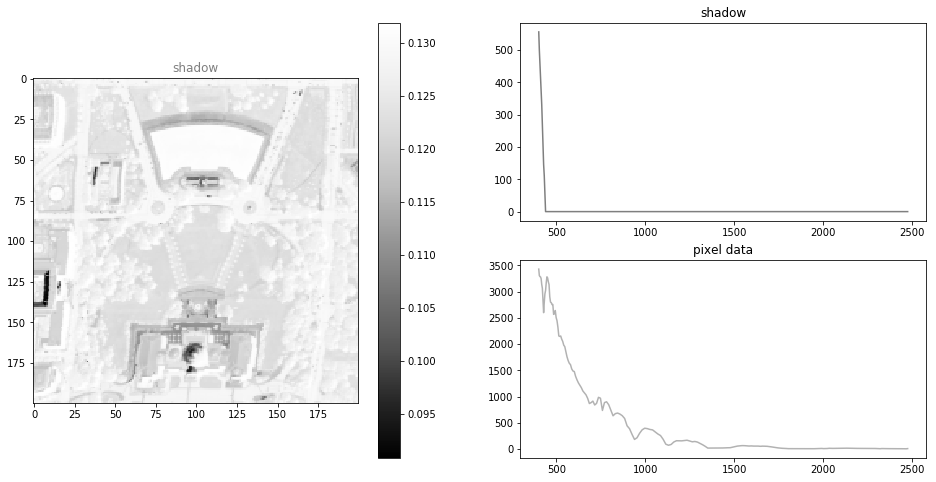

In [7]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, (obj,(x,y)) in enumerate(points.items()):
    spec = get_point_spec(x, y, data)
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title(obj, color=color_cycle[idx])
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,4)
    ax2.set_title(obj)
    img = S[idx].reshape(img_shape)
    img_plot = ax1.imshow(img, cmap="Greys_r")
    fig.colorbar(img_plot, ax=ax1)
    ax2.plot(wavelength, A[:,idx], color=color_cycle[idx])
    ax3.plot(wavelength, spec, color=color_cycle[idx], alpha=.6)
    ax3.set_title("pixel data")
    plt.show()

In [8]:
np.sum(S, axis=0)

array([ 1.00142708,  1.00159298,  1.0015761 , ...,  1.00073515,
        1.00090297,  1.00143711])

In [9]:
list(points.keys())

['water', 'path', 'grass', 'roof', 'concrete', 'trees', 'road', 'shadow']

In [10]:
colors = {
    'water': '#0000ff',
    'grass': '#00ff00',
    'roof': '#07afc1',
    'concrete': '#e0e0e0',
    'path': '#7c600b',
    'trees': '#2c702c',
    'road': '#424242',
    'shadow': '#000000'
}
cmaplist = [
    (int('0x'+colors[obj][1:3], 16),
     int('0x'+colors[obj][3:5], 16),
     int('0x'+colors[obj][5:7], 16))
    for obj in list(points.keys())]
cmaplist = [colors[obj] for obj in list(points.keys())]
from matplotlib import colors
cmap = colors.ListedColormap(cmaplist)

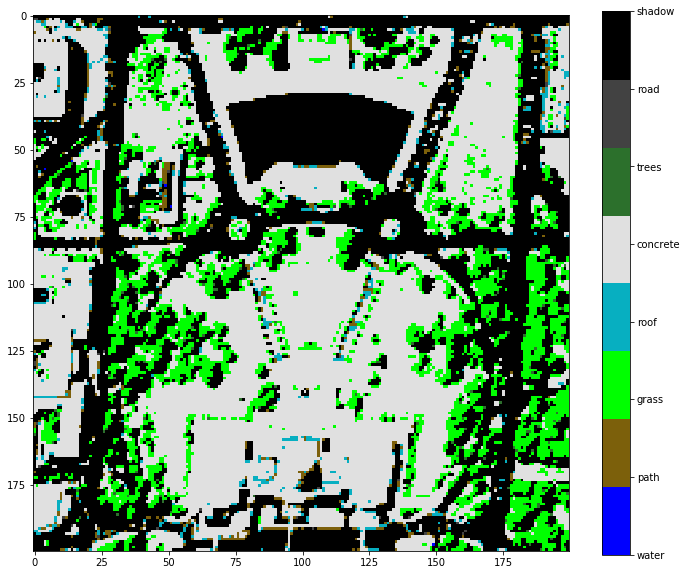

In [11]:
Smax = np.argmax(S, axis=0)
plt.figure(figsize=(12,10))
plt.imshow(Smax.reshape(img_shape), cmap=cmap)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(list(points.keys()))
plt.show()

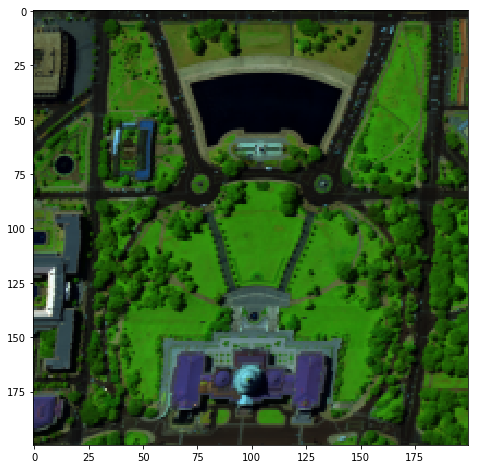

In [33]:
plt.figure(figsize=(8,8))

b = np.sum(data[:50], axis=0).reshape(img_shape)
g = np.sum(data[50:100], axis=0).reshape(img_shape)
r = np.sum(data[100:], axis=0).reshape(img_shape)

b = b-np.min(b)
g = g-np.min(g)
r = r-np.min(r)

b = b/np.max(b)
g = g/np.max(g)
r = r/np.max(r)

#rgb = np.dstack([r,g,b])
rgb = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)
plt.imshow(rgb)

In [ ]:
obj_count = 5
thresh = .1

# Initialize A0 so that each object has a normalized spectrum
A0 = np.random.rand(shape[0], obj_count)*np.max(data)
prox_A = proxmin.operators.prox_plus

# Initialize S0
S0 = np.random.rand(obj_count, img_shape[0]*img_shape[1])
norm = np.sum(S0, axis=0)
S0 = S0/norm
S0[S0<thresh] = 0
norm = np.sum(S0, axis=0)
S0 = S0/norm

Ls = [[None], [np.ones((1,S0.shape[0]))]]

def prox_ones(X, step):
    return np.ones_like(X)

prox_g = [[proxmin.operators.prox_id],[prox_ones]]

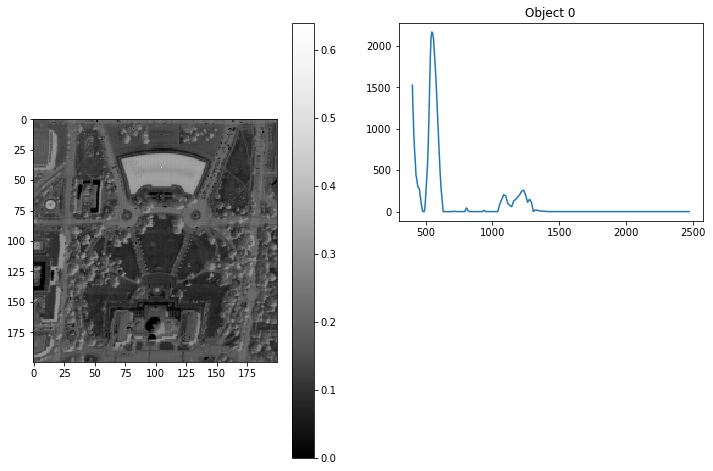

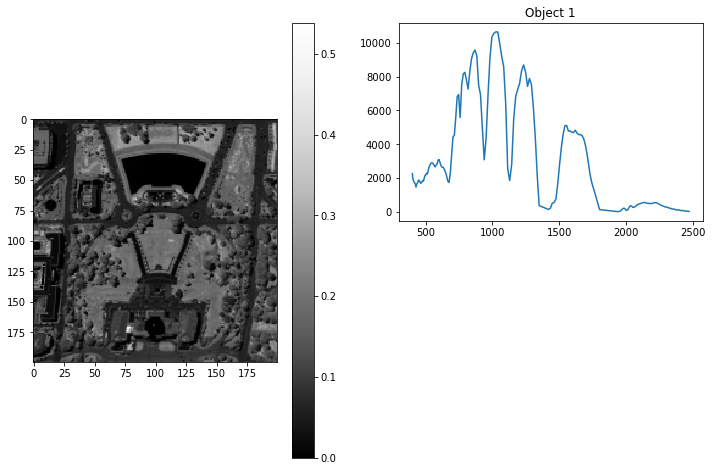

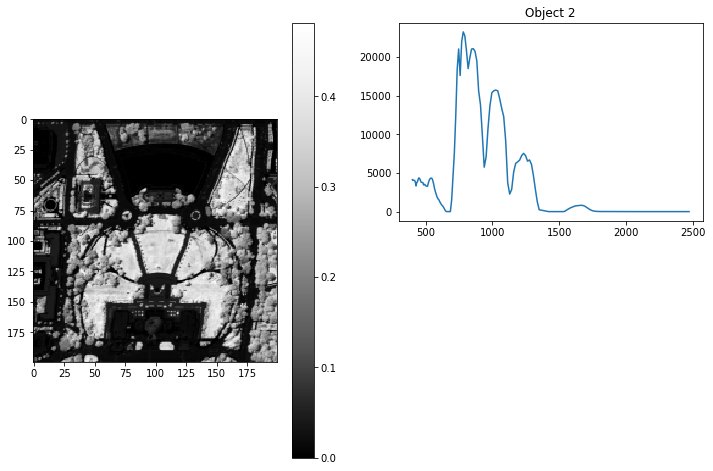

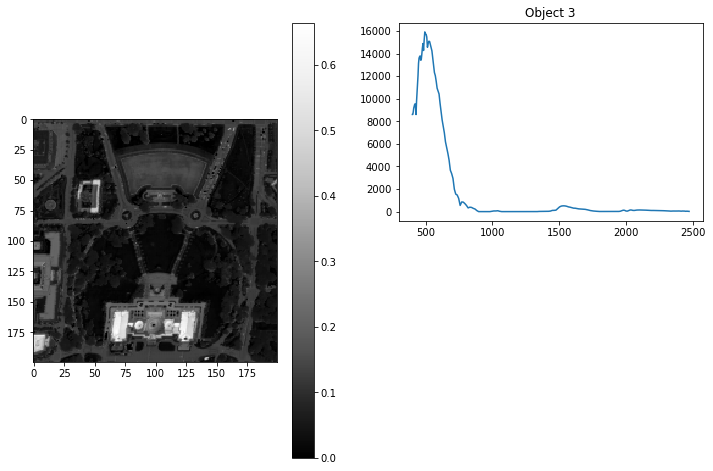

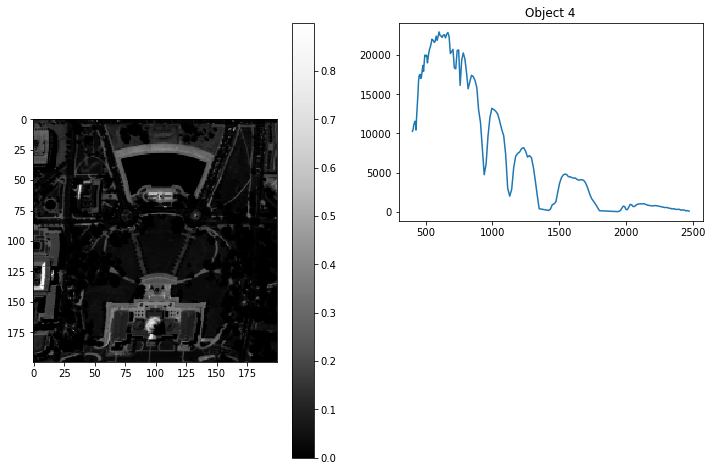

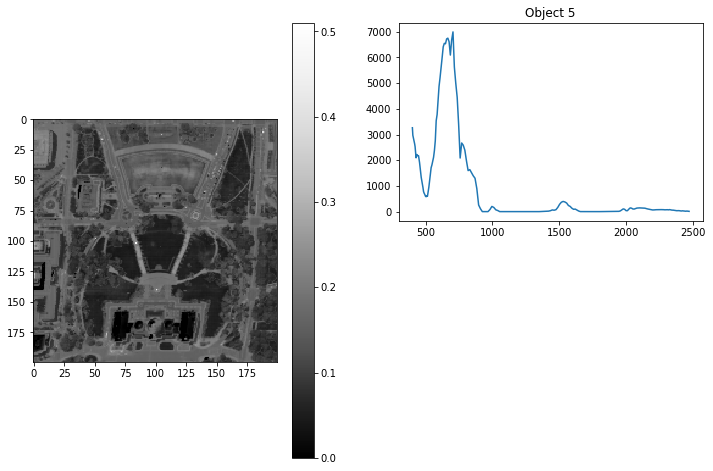

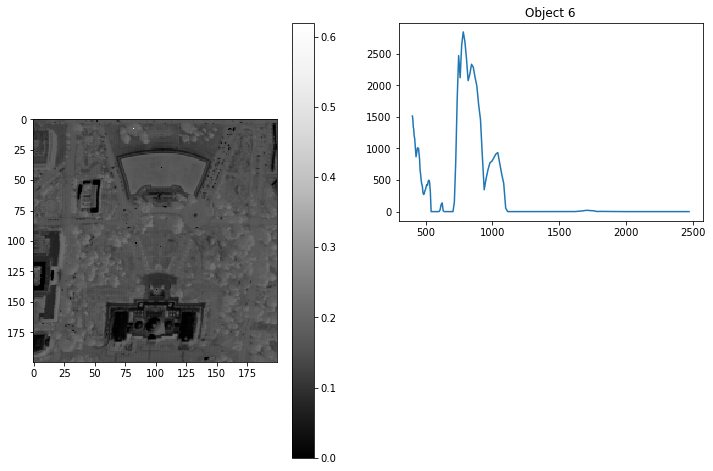

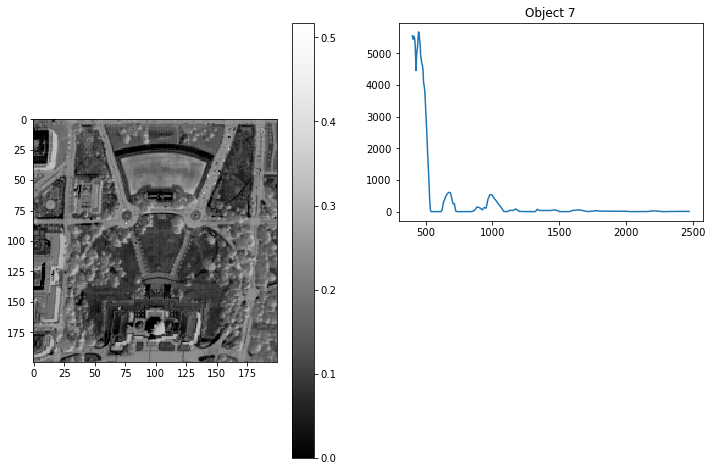

In [69]:
for idx in range(S.shape[0]):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax2.set_title("Object {0}".format(idx))
    img = S[idx].reshape(img_shape)
    img_plot = ax1.imshow(img, cmap="Greys_r")
    fig.colorbar(img_plot, ax=ax1)
    ax2.plot(wavelength, A[:,idx])
    plt.show()

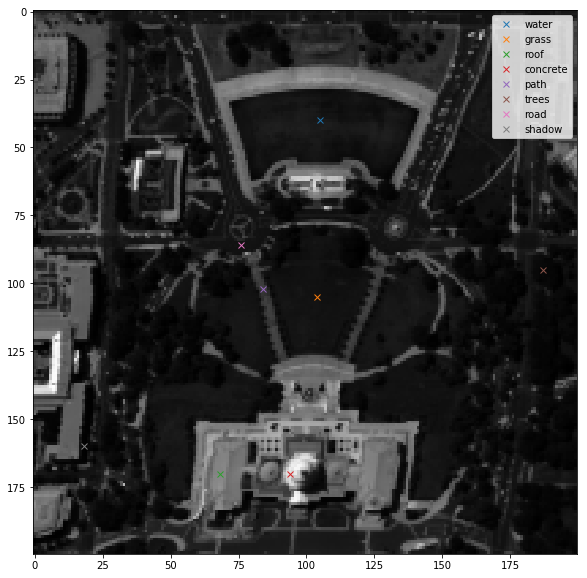

In [250]:
points = OrderedDict([
    ('water', (105, 40)),
    #('dirty grass', (108, 12)),
    ('grass', (104, 105)),
    ('roof', (68, 170)),
    ('concrete', (94, 170)),
    ('path', (84, 102)),
    #('trees', (82, 8)),
    ('trees', (187, 95)),
    ('road', (76, 86)),
    ('shadow', (18, 160))
])
plt.figure(figsize=(10,10))
#plt.imshow(data[110].reshape(img_shape), cmap="Greys_r")
plt.imshow(data[40].reshape(img_shape), cmap="Greys_r")
for obj, pt in points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
plt.legend()
plt.show()

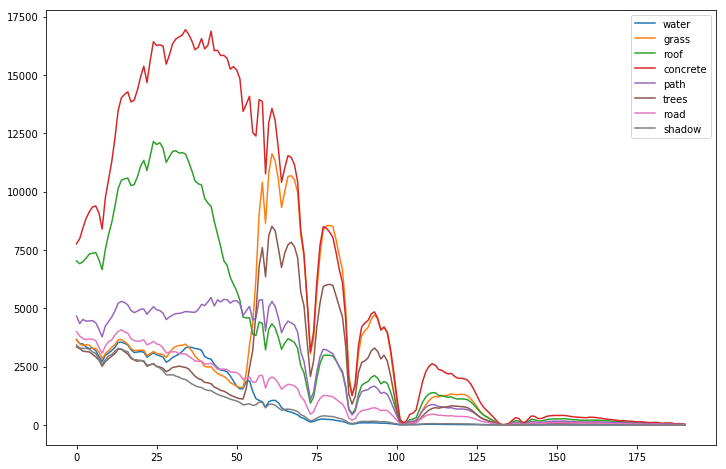

In [251]:
def get_point_spec(x, y, data):
    return data[:,img_shape[1]*y+x]

plt.figure(figsize=(12,8))


for obj,(x,y) in points.items():
    spec = get_point_spec(x, y, data)
    #plt.plot(wavelength, spec, label=obj)
    plt.plot(spec, label=obj)
plt.legend()

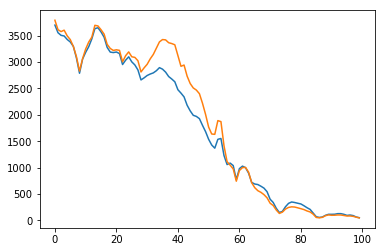

In [336]:
plt.plot(A[:,5])
spec = get_point_spec(60, 40, data)
plt.plot(spec)

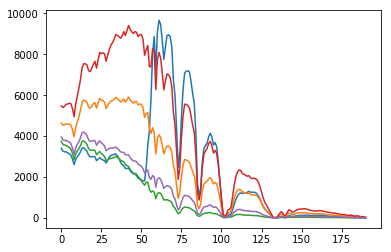

In [212]:
for n in range(A.shape[1]):
    plt.plot(A[:,n])
plt.show()

In [223]:
model = A.dot(S)
residual = data-model

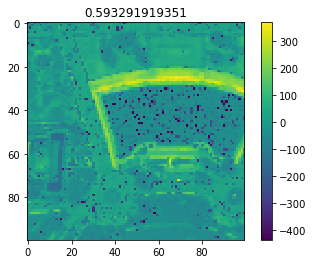

In [239]:
n=150
plt.imshow(residual[n].reshape(img_shape))
plt.title(np.max(residual[n]/np.max(data[n])))
plt.colorbar()